# Multi-Head attention

1. Visualization of attention matrices $Q\cdot K^T$
2. Analysis of matrix symmetry

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/Users/miriamzara/LCP_B_GPT2/my_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Investigation of heads functional roles


To do:
-  Check if some heads consistently focus on specific token types (e.g., syntax, entities, punctuation).”
- Quantify how often each head attends to positional information versus semantic content.”

In [ ]:
syntax_prompts = [
    "The cat that chased the mouse was very quick.", # cat -> was
    "Although she was tired, the scientist completed the experiment.", # she -> the scientist
    "The group of students is planning a trip.", # group -> is
    "The keys on the table belong to the guests.", # keys -> belong
    "I saw the man with the telescope."
]

semantic_prompts = [
    "Mary gave Jane her book because she was finished reading it.",
    "The lawyer told the doctor that he needed to rest.",
    "Google acquired YouTube in 2006.",
    "Einstein developed the theory of relativity.",
    "The bank can guarantee deposits will be safe.",
    "He sat on the bank of the river."
]

positional_prompts = [
    "She eats apples.",
    "Apples she eats.",
    "Tomorrow, I will go to the market.",
    "I will go to the market tomorrow.",
    "The book that the professor who won the award wrote is fascinating."
]

subject_verb_agreement_prompts = [
    "The dog runs fast.",
    "The dogs run fast.",
    "Neither the boy nor the girls are ready.",
    "Each of the players has a unique skill."
]

discourse_prompts = [
    "Because it rained, the streets were flooded.",
    "She studied hard; therefore, she passed the exam.",
    "Although he was tired, he kept working.",
    "She likes coffee, but he prefers tea."
]

ambiguous_prompts = [
    "Visiting relatives can be annoying.",
    "Time flies like an arrow; fruit flies like a banana."
]

### 1. Visualization of attention matrices

In [3]:
model = AutoModelForCausalLM.from_pretrained("gpt2", output_attentions=True, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model.eval()

prompt = "On Friday, the judge issued a sentence"
inputs = tokenizer(prompt, return_tensors="pt")
input_ids = inputs["input_ids"]
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# Forward pass
with torch.no_grad():
    outputs = model(**inputs)

attentions = outputs.attentions  # List of tensors: [layer][batch, head, seq_len, seq_len], head = Et
hidden_states = outputs.hidden_states  # Tuple: (embeddings + 12 layers), hidden_states = each "line" (1dim of a tensor) è X_seq

# Language modeling head
lm_head = model.lm_head  # Linear layer from hidden dim -> vocab size
top_k = 15  # Change as needed
token_position = -1  # Last token in prompt


"""
print(f"Prompt: {prompt}\n")

for i in range(1, n_layers):  # skip embeddings (index 0)
    hidden = hidden_states[i]  # shape: [1, seq_len, hidden_dim]
    last_token_vec = hidden[0, token_position, :]  # shape: [hidden_dim]
    logits = lm_head(last_token_vec)  # shape: [vocab_size]
    probs = torch.softmax(logits, dim=-1)

    # Avoid log(0) by masking zero probabilities -> else you get 0*-inf = nan when probs are zero
    mask = probs > 0
    entropy = -torch.sum(probs[mask] * torch.log2(probs[mask])).item()

    top_probs, top_ids = torch.topk(probs, top_k)
    top_tokens = tokenizer.convert_ids_to_tokens(top_ids)

    print(f"Layer {i:2d}: Entropy = {entropy:.4f}")
    for j in range(top_k):
        print(f"  {j+1:2d}: {top_tokens[j]:>10} ({top_probs[j].item():.4f})")
"""

num_heads = 12
def plot_attention_layers(attentions, tokens):
    num_layers = len(attentions)
    fig, axes = plt.subplots(nrows = num_heads, ncols= num_layers, figsize=(5 * num_layers, 4 * num_heads))
    fig.suptitle(f"Attention Heatmaps", fontsize=16)
    for head_idx in range(num_heads):
        for i in range(num_layers):
            ax = axes[head_idx, i]
            attn = attentions[i][0, head_idx, :, :].detach().numpy()
            mask = np.triu(np.ones_like(attn, dtype=bool), k = +1)
            sns.heatmap(attn, xticklabels=tokens, yticklabels=tokens, cmap="Reds", vmin = 0, vmax = 1, ax=ax, square=True, cbar=True, mask = mask)
            ax.tick_params(axis='y', rotation=0)
            ax.tick_params(axis='x', rotation=90)
    #        ax.set_xticks([])
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig(f"prova_heads.png", dpi = 300)
    plt.show()


#plot_attention_layers(attentions, tokens)

/Users/miriamzara/LCP_B_GPT2/my_venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
/Users/miriamzara/LCP_B_GPT2/my_venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


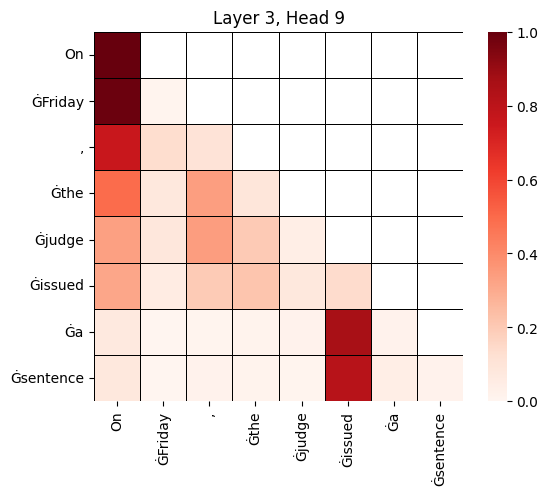

In [9]:
# 9,10
# layer 3

i = 2
head_idx = 8
fig, ax = plt.subplots()
attn = attentions[i][0, head_idx, :, :].detach().numpy()
mask = np.triu(np.ones_like(attn, dtype=bool), k = +1)
sns.heatmap(attn, xticklabels=tokens, yticklabels=tokens, cmap="Reds", vmin = 0, vmax = 1, ax=ax, square=True, cbar=True, mask = mask, linecolor = "black", linewidth = 0.5)
ax.set_title(f"Layer {i+1}, Head {head_idx + 1}")
plt.savefig(f"lay_{i+1}_head_{head_idx+1}.png")

### Multi-head Attention Matrices


$$ Q\cdot K^T = X\,(W_Q \cdot W_K^T)\,X^T$$
Here we search for a possible mathematical interpretation of the linear transformations involved in the computation of $Q, K, V$ in multi-head attention. Specifically, we want to answer the following questions:


In single head attention:

- how different is the matrix $W_Q \cdot W_K^T$ from the identity matrix? If we find a significative difference, it means that the attention is doing something more than $X\cdot X^T$ - i.e. the projection of the buffer on itself;

- is $W_Q \cdot W_K^T$ symmetric? In that case, the attention weights can be seen as $X' \cdot X'^T$ where $X' = A\cdot X$.

In [6]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load pretrained model
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
state_dict = model.state_dict()

### Attention matrices


1 - Transformation to queries, keys, values. Matrices are stacked together horizontally (column- wise). This way, only 1 matrix multiplication is required instead of 3.
$$
\begin{align}
    [Q, K, V] &= X \cdot [W_Q, W_K, W_V] + 
    \begin{pmatrix}
        \text{bias QKV} \\
        \cdots \\
        \text{bias QKV}
    \end{pmatrix} \\
    (N \cdot 3D) &= (N \cdot D) \cdot (D \cdot 3D) + (N \cdot 3D)
\end{align}
$$
2 - Splitting into heads:

$ \begin{align}
    Q &\rightarrow [Q_1, \cdots, Q_{n_H}] \\
    (N \cdot D) &=  \text{list of}\,\, (N \cdot d_K)  \\
\end{align}
$

3 - Attention computation:
$ \begin{align}
    \text{head h} &= \text{softmax}\left( \frac{Q_h\cdot K_h^T}{\sqrt{d_K} } \right) [Q_1, \cdots, Q_{n_H}] \\
    (N \cdot D) &=  \text{list of}\,\, (N \cdot d_K)  
\end{align}
$

4 - Backwards projection

$
\begin{align}
Y_{out} &= [\vec{1}, \mathbf{Y}_\text{head 1},\, \mathbf{Y}_\text{head 2} \cdots, \mathbf{Y}_\text{head nH}] \cdot
    \begin{pmatrix}
        \text{bias}_0 \\
        \mathbf{W}_0 \\
    \end{pmatrix} \\
   { \footnotesize (N \times D )} &= { \footnotesize (N\, \times\, D+ 1) \cdot (D+ 1 \, \times \, D)}\\
\end{align}
$

$$


\vec{y}_i =\sum_{j=1}^{N}\,\, A_{i,\,j}\,\vec{v}_j \longrightarrow \mathbf{Y} = \mathbf{A}\cdot \mathbf{V}

$$


$$
A_{i,\,j} = \frac{\exp \left(\frac{\langle \vec{q}_i,\, \vec{k}_j\rangle}{d_h}\right)}{\mathcal{N}_i } = \frac{\exp\left(\frac{[\mathbf{Q}\,\mathbf{K}^T]_{i,\,j}}{d_h}\right)}{\mathcal{N}_i }
$$

$$
\mathcal{N}_i =\sum_{l=1}^{N} \, \exp \left(\frac{[\mathbf{Q}\,\mathbf{K}^T]_{i,\,l}}{d_h}\right)  \longrightarrow \sum_{j=1}^{N}\, A_{i,\,j} = 1 \quad \forall\,\, i
$$

$$
A_{i,\,j} \sim \langle \vec{q}_i,\, \vec{k}_j \rangle
$$

In [7]:
layer_max = 12
qkv_weights = [state_dict[f"transformer.h.{i}.attn.c_attn.weight"].cpu().detach().numpy() for i in range(0, layer_max)] # list of N x (3D) matrices
qkv_biases = [state_dict[f"transformer.h.{i}.attn.c_attn.bias"].cpu().detach().numpy() for i in range(0, layer_max)] # list of D x 1 vectors
projection_weights = [state_dict[f"transformer.h.{i}.attn.c_proj.weight"].cpu().detach().numpy() for i in range(0, layer_max)] # list of D x D matrices
projection_biases = [state_dict[f"transformer.h.{i}.attn.c_proj.bias"].cpu().detach().numpy() for i in range(0, layer_max)] # list of D x 1 vectors
print(qkv_weights[0].shape)
print(qkv_biases[0].shape)
print(projection_weights[0].shape)
print(projection_biases[0].shape)

(768, 2304)
(2304,)
(768, 768)
(768,)


In [ ]:
from numpy.linalg import norm
D = 768
num_heads = 12
d_head = D // num_heads  # = 64
layer_max = 12  # number of transformer layers

Wq = [qkv_weights[i][:, 0:D]       for i in range(layer_max)]      # shape (D, D)
Wk = [qkv_weights[i][:, D:2*D]     for i in range(layer_max)]      # shape (D, D)
Wv = [qkv_weights[i][:, 2*D:3*D]   for i in range(layer_max)]      # shape (D, D)
W0 = projection_weights

Wq_head = np.array([[w[:, head_idx*d_head:(head_idx+1)*d_head] for head_idx in range(num_heads)] for w in Wq])
Wk_head = np.array([[k[:, head_idx*d_head:(head_idx+1)*d_head] for head_idx in range(num_heads)] for k in Wk])
Wv_head = np.array([[v[:, head_idx*d_head:(head_idx+1)*d_head] for head_idx in range(num_heads)] for v in Wv])



assert Wq_head.shape == (layer_max, num_heads, D, d_head)  # (12, 12, 768, 64)



M_head = np.array([
    [np.matmul(Wq_head[layer, head], Wk_head[layer, head].T) for head in range(num_heads)]
    for layer in range(layer_max)
])



# norm of M_h itself
M_norm = norm(M_head, axis = (2, 3))
M_norm.shape # (num layers, num heads)


# || M_h - 1_D ||
I = np.eye(D)
dist_id = norm(M_head - I[None, None, :, :], axis=(2, 3))

# Need transpose over last two axes
M_T = np.transpose(M_head, axes=(0, 1, 3, 2))  # (layers, heads, D, D)
dist_T = norm(M_head - M_T, axis=(2, 3))

# scaled

dist_id_scaled = dist_id / (norm(I) + M_norm + dist_id)  # scalar + array + array
dist_T_scaled = dist_T / (2 * M_norm + dist_T)

### Checking the normalized distance across heads and layers.


$$
d(A, B) = \frac{||A-B||}{||A|| + ||B|| + ||A-B||}
$$

is a metric on the space of square matrices, with || . || indicating the Frobenius norm.

It is also normalized to the size of A and B, thus giving a measure of the relative dissimilarity of A and B, relative to their sizes.

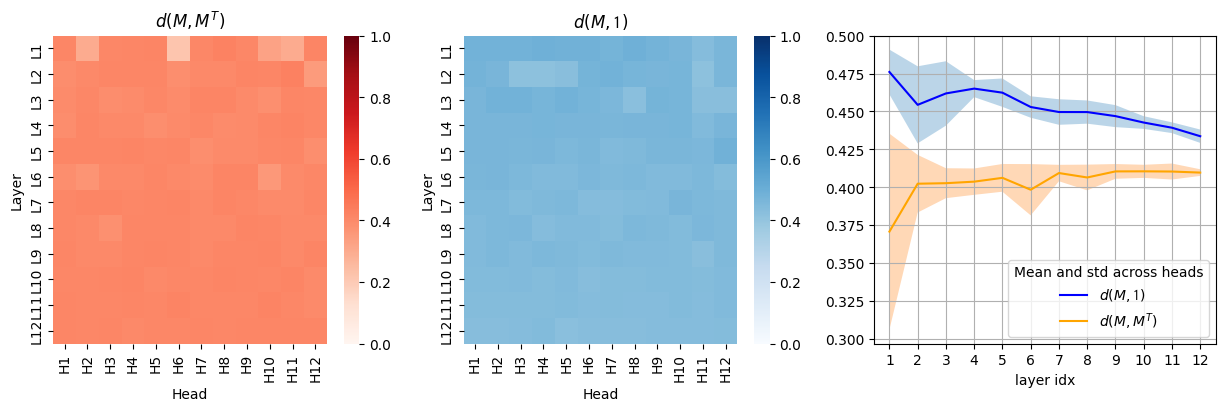

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set aesthetic

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 4))

def plot_heatmap(data, ax, title, cmap="viridis"):
    sns.heatmap(data,ax = ax, annot=False, cmap=cmap, cbar=True,
                     xticklabels=[f"H{h+1}" for h in range(num_heads)],
                     yticklabels=[f"L{l+1}" for l in range(layer_max)], vmin = 0, vmax = 1)
    ax.set_xlabel("Head")
    ax.set_ylabel("Layer")
    ax.set_title(title)

# Visualizations
plot_heatmap(dist_T_scaled, axs[0], r"$d(M,M^T)$", cmap="Reds")
plot_heatmap(dist_id_scaled, axs[1], r"$d(M, \mathcal{1})$", cmap="Blues")



mean = np.mean(dist_id_scaled, axis = 1)
std = np.std(dist_id_scaled, axis = 1)
axs[2].plot(1 + np.arange(0, layer_max ), mean, color= "blue", label = r"$ d(M, \mathcal{1})$")
axs[2].fill_between(1+np.arange(0, layer_max ), y1 = mean - std, alpha = 0.3, y2 = mean + std)


mean = np.mean(dist_T_scaled, axis = 1)
std = np.std(dist_T_scaled, axis = 1)
axs[2].plot(1 + np.arange(0, layer_max ), mean, color = "orange", label = r"$ d(M, M^T)$")
axs[2].fill_between(1+ np.arange(0, layer_max), y1 = mean - std, alpha = 0.3, y2 = mean + std)

axs[2].set_xlabel("layer idx")
axs[2].set_xticks(np.arange(1, 13))
axs[2].legend(title = "Mean and std across heads")
axs[2].grid()
plt.savefig("../miriam/attention_symm_for_slides.png",dpi = 300)

### Visualization of absolute norms of the W matrices, layer per layer


The complete W-s are doing a change of basis in R^D. Then, the splitting in heads takes projections over subspaces of dim <= d_h.

So lets look at this change of basis.

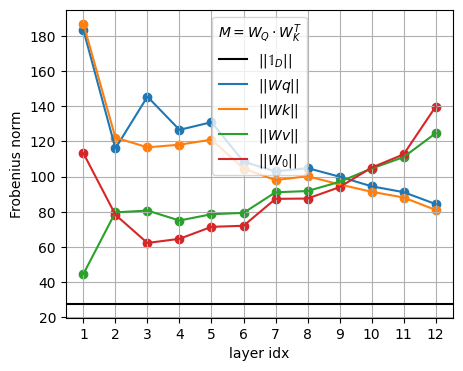

In [25]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,4))
plt.subplots_adjust(hspace = 0.3)


ax.axhline(y = norm(np.eye(D)), color = "black", label = r"$||\mathbb{1}_D||$")


ax.plot(np.arange(1, layer_max + 1), [norm(w) for w in Wq] , label = r"$||Wq||$")
ax.scatter(np.arange(1, layer_max + 1), [norm(w) for w in Wq])

ax.plot(np.arange(1, layer_max + 1), [norm(w) for w in Wk], label = r"$||Wk||$")
ax.scatter(np.arange(1, layer_max + 1), [norm(w) for w in Wk])

ax.plot(np.arange(1, layer_max + 1), [norm(w) for w in Wv], label = r"$||Wv||$")
ax.scatter(np.arange(1, layer_max + 1), [norm(w) for w in Wv])

ax.plot(np.arange(1, layer_max + 1), [norm(w) for w in W0], label = r"$||W_0||$")
ax.scatter(np.arange(1, layer_max + 1), [norm(w) for w in W0])

#ax.plot(np.arange(1, layer_max + 1), [norm(w @ Wv[i]) for i, w in enumerate(W0)], label = r"$||W_0 \cdot W_V||$")
#ax.scatter(np.arange(1, layer_max + 1), [norm(w @ Wv[i]) for i, w in enumerate(W0)])


ax.grid()
ax.set_xlabel("layer idx")
ax.set_ylabel("Frobenius norm")
ax.set_xticks(np.arange(1, 13))
ax.legend(title = r"$M = W_Q\cdot W_K^T$")

$$

\Lambda^{1/2} = \text{diag}(\sqrt{\lambda_1}, \dots, \sqrt{\lambda_n}) \\

M = AA^T  (= U \Lambda^{1/2} \Lambda^{1/2} U^T)

$$


$$
\Sigma = \begin{pmatrix}
\sigma_1 & 0        & \cdots & 0 \\
0        & \sigma_2 & \cdots & 0 \\
\vdots   & \vdots   & \ddots & \vdots \\
0        & 0        & \cdots & \sigma_D
\end{pmatrix}
$$

### How different are $W_V$ and $W_0$ ?

- Is $W_0$ (more or less) the inverse of $W_V$?
- How large is the bias term, in both terms? Why there is one?

In [ ]:
from numpy.linalg import norm
D = 768
num_heads = 12
d_head = D // num_heads  # = 64
layer_max = 12  # number of transformer layers


Wv = [qkv_weights[i][:, 2*D:3*D]   for i in range(layer_max)]      # shape (D, D)
W0 = [projection_weights[i] for i in range(layer_max)]

Wv_head = np.array([[v[:, head_idx*d_head:(head_idx+1)*d_head] for head_idx in range(num_heads)] for v in Wv])
W0_head = np.array([[w0[:, head_idx*d_head:(head_idx+1)*d_head] for head_idx in range(num_heads)] for w0 in W0])

composed = np.array([
    [np.matmul(Wv_head[layer, head], W0_head[layer, head]) for head in range(num_heads)] for layer in range(layer_max) ])




#dist_v0 = [norm(wv - W0[i])/ (norm(wv) + norm(W0[i]) + norm(wv-W0[i]) ) for i, wv in enumerate(Wv)]
dist_composed = [[norm(composed[layer, head] - np.eye(d_head))/ (norm(composed[layer, head]) + norm(np.eye(d_head)) + norm(composed[layer, head]-np.eye(d_head)) ) for head in range(num_heads)] for layer in range(layer_max)]

fig, ax = plt.subplots()
plot_heatmap(dist_composed, ax, r"$d(M, \mathcal{1})$", cmap="Blues")



#ax.plot(range(layer_max), [norm(v-w0bias[i])/(norm(v) + norm(w0bias[i]) + norm(v- w0bias[i])) for i, v in enumerate(vbias)])

#ax.plot(range(layer_max), [norm(v) for v in qbias])
#ax.plot(range(layer_max), [norm(v) for v in kbias])
#ax.plot(range(layer_max), [norm(v) for v in vbias])
#ax.plot(range(layer_max), [norm(v) for v in w0bias])


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 768 is different from 64)

### 3. Computing ranks of the transformation matrices.

$W_Q, W_K, W_V, W_0$ : are they projections or change of basis?


Do they preserve distances? Do they preserve angles?

In [12]:
import numpy as np

q_rank = [np.linalg.matrix_rank(q) for q in Wq]
k_rank = [np.linalg.matrix_rank(k) for k in Wk]
v_rank = [np.linalg.matrix_rank(v) for v in Wv]
w0_rank = [np.linalg.matrix_rank(w0) for w0 in W0]

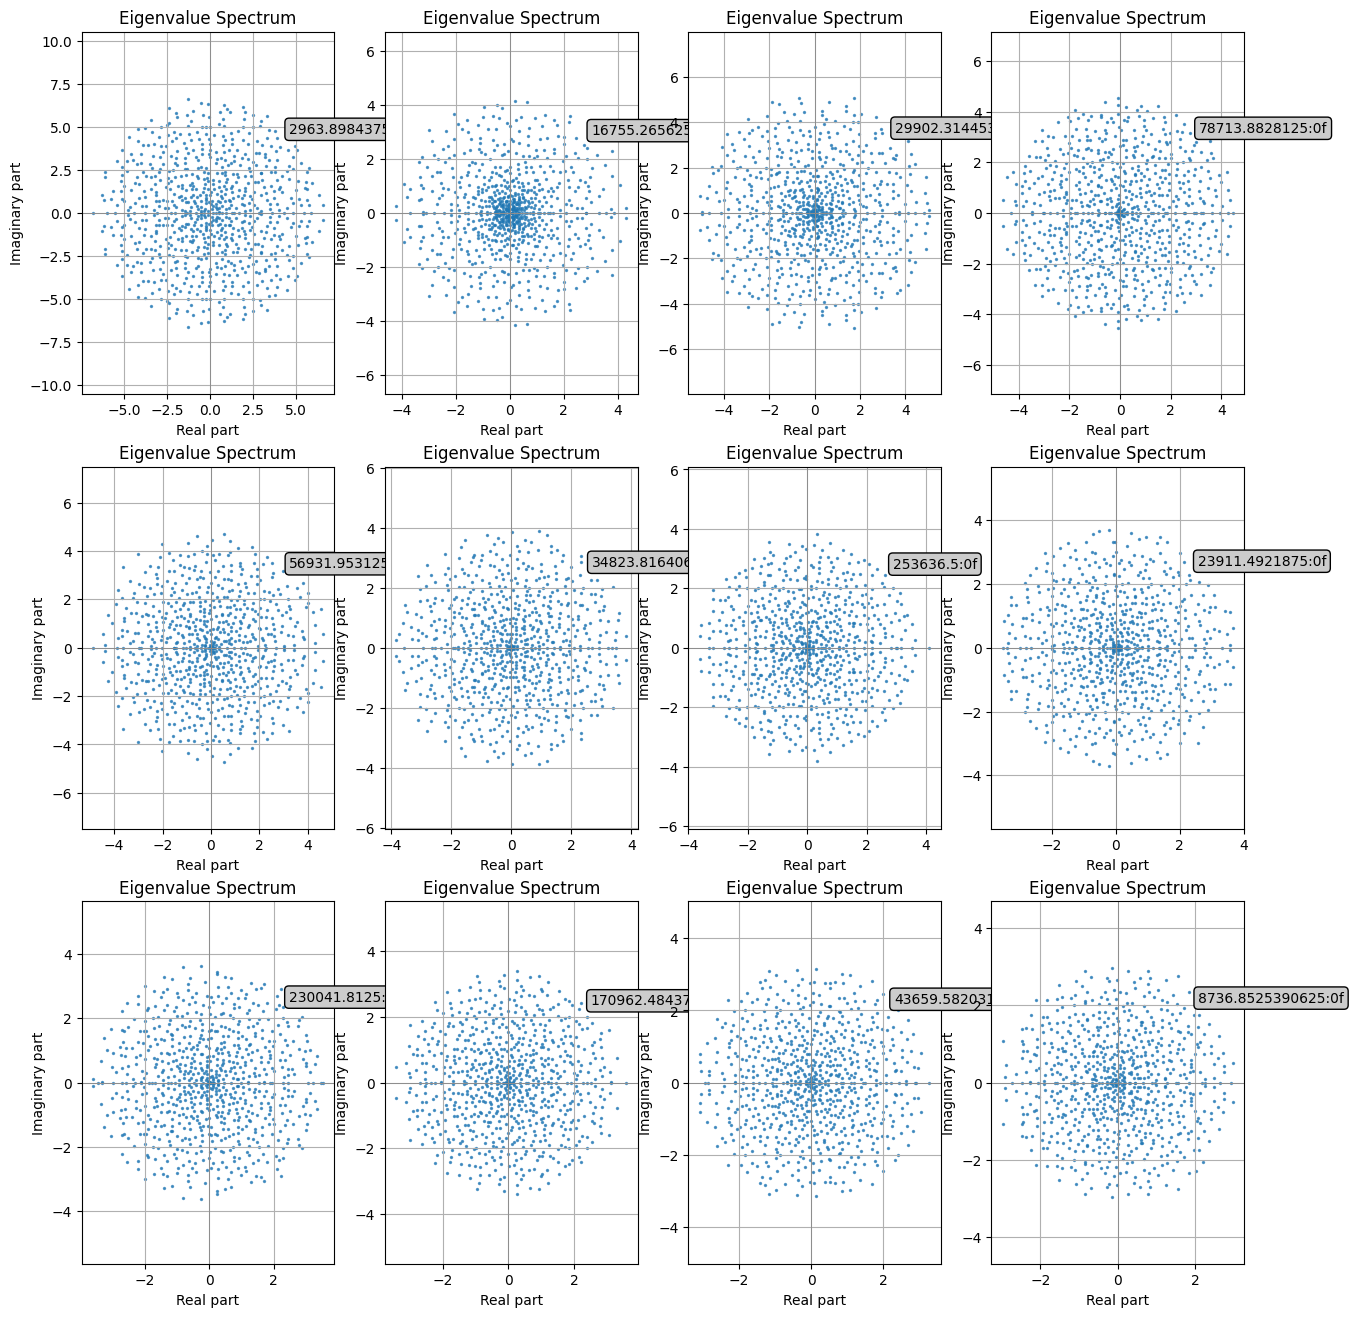

In [37]:
fig, axs = plt.subplots(nrows = 3, ncols = 4, figsize=(5*3,4*4))
axs = axs.flatten()

bbox = dict(boxstyle="round", fc="0.8")

for i in range(0, layer_max):

    A = q_weights[i]
    eigvals = np.linalg.eigvals(A)
    cond_number = np.linalg.cond(A)
    axs[i].annotate(text= f"{cond_number}:0f", xy = (max(eigvals.real)*0.7, max(eigvals.imag)*0.7), bbox = bbox)
    axs[i].scatter(eigvals.real, eigvals.imag, s=2, alpha=0.7)
    axs[i].axhline(0, color='gray', linewidth=0.5)
    axs[i].axvline(0, color='gray', linewidth=0.5)
    axs[i].set_xlabel('Real part')
    axs[i].set_ylabel('Imaginary part')
    axs[i].set_title('Eigenvalue Spectrum')
    axs[i].grid(True)
    axs[i].axis('equal')


You’re likely observing:
- A linear transformation that scrambles the space, mixing directions with complex shearing, non-uniform scaling, and non-normal behavior.
- The fact that eigenvalues are inside a disk (not just on the unit circle) means it compresses some directions (i.e., not volume-preserving).

So: the circle is not a “structured” geometric transformation like rotation or scaling — it’s a signature of randomness and loss of geometric meaning.

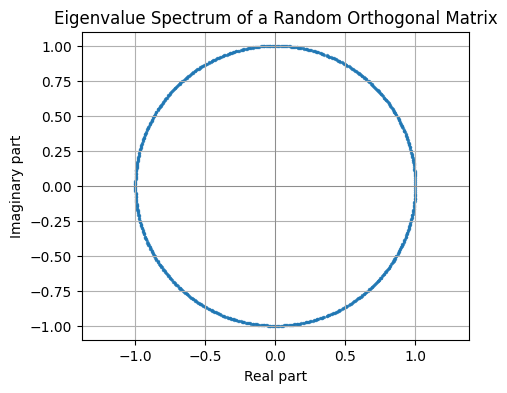

In [29]:

# Step 1: Generate a random matrix
A = np.random.randn(789, 789)
Q, R = np.linalg.qr(A)
# Q is now orthogonal: Q.T @ Q ≈ I
eigvals = np.linalg.eigvals(Q)

plt.figure(figsize=(5,4))
plt.scatter(eigvals.real, eigvals.imag, s=2, alpha=0.7)
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.title('Eigenvalue Spectrum of a Random Orthogonal Matrix')
plt.grid(True)
plt.axis('equal')
plt.show()

Is A orthogonal? False
Condition number: 2963.8984


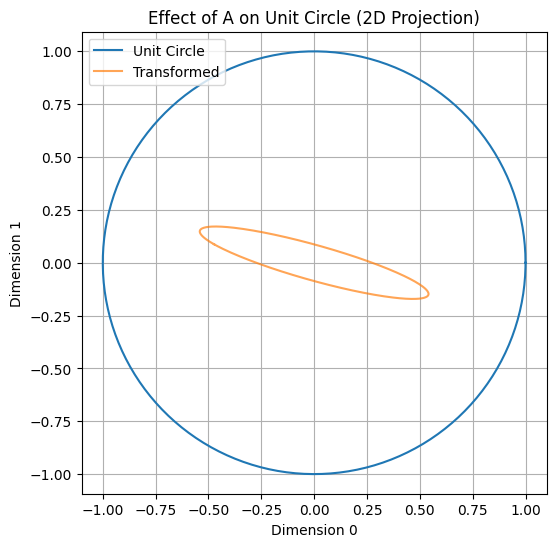

In [31]:
A = q_weights[0]
n = A.shape[0]
# 1. ✅ Check if A is orthogonal
is_orthogonal = np.allclose(A.T @ A, np.eye(n), atol=1e-6)
print("Is A orthogonal?", is_orthogonal)

# 2. ✅ Condition number (ratio of largest to smallest singular value)
cond_number = np.linalg.cond(A)
print("Condition number:", cond_number)

# 3. ✅ Visualize transformation of unit sphere

# Pick a 2D plane (e.g. first 2 dimensions)
dim1, dim2 = 0, 1
num_points = 300

# Generate points on unit circle in 2D subspace
theta = np.linspace(0, 2*np.pi, num_points)
unit_circle = np.zeros((n, num_points))
unit_circle[dim1, :] = np.cos(theta)
unit_circle[dim2, :] = np.sin(theta)

# Transform the circle with A
transformed = A @ unit_circle

# Plot
plt.figure(figsize=(6,6))
plt.plot(unit_circle[dim1], unit_circle[dim2], label='Unit Circle')
plt.plot(transformed[dim1], transformed[dim2], label='Transformed', alpha=0.7)
plt.xlabel(f"Dimension {dim1}")
plt.ylabel(f"Dimension {dim2}")
plt.title("Effect of A on Unit Circle (2D Projection)")
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

📈 Condition number ≈ 2964 (not terrible, but not great)
	•	This measures how much the matrix distorts space.
	•	A condition number ≈ 1 means near-orthogonal (ideal).
	•	Your value suggests some directions are stretched ~3000× more than others, but it’s not catastrophic (e.g., not 10^8).

📐 Transformed unit circle = ellipse
	•	Confirms that some directions are amplified, others are compressed.
	•	Geometrically, your matrix is a non-uniform linear transformation — likely combining rotation + anisotropic scaling.

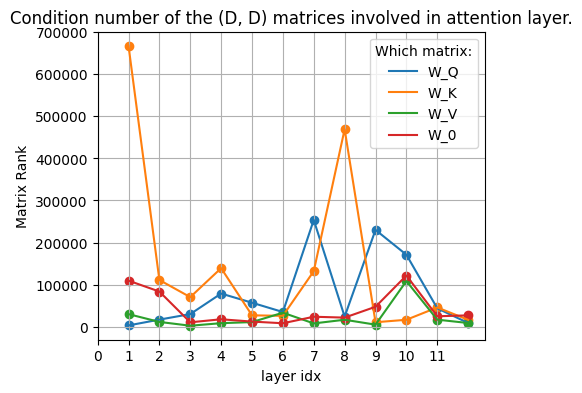

In [39]:
q_number = [np.linalg.cond(A) for A in q_weights]
k_number = [np.linalg.cond(A) for A in k_weights]
v_number = [np.linalg.cond(A) for A in v_weights]
w0_number = [np.linalg.cond(A) for A in w0_weights]



fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(5, 4))




axs.plot(np.arange(1, layer_max + 1), q_number, label = "W_Q")
axs.scatter(np.arange(1, layer_max + 1), q_number)

axs.plot(np.arange(1, layer_max + 1), k_number, label = "W_K")
axs.scatter(np.arange(1, layer_max + 1), k_number)

axs.plot(np.arange(1, layer_max + 1), v_number, label = "W_V")
axs.scatter(np.arange(1, layer_max + 1), v_number)

axs.plot(np.arange(1, layer_max + 1), w0_number, label = "W_0")
axs.scatter(np.arange(1, layer_max + 1), w0_number)



axs.grid()
axs.set_title("Condition number of the (D, D) matrices involved in attention layer.")
axs.set_xlabel("layer idx")
axs.set_ylabel("Matrix Rank")
axs.set_xticks(np.arange(0, 12))

axs.legend(title = "Which matrix:")

🧠 What does this mean?

A condition number ≈ 10^5 means:
	•	W_Q stretches some directions 100,000× more than others
	•	It is very sensitive to input perturbations in X
	•	In geometric terms: the input space is squashed along some directions and exploded along others

⸻

🧬 Why does this matter for attention?

1. Q = X·W_Q projects inputs into “query space”
	•	A poorly conditioned W_Q means:
	•	Small variations in X may lead to large or unstable differences in Q
	•	Some directions in the input are essentially ignored (near-zero amplification)
	•	Others dominate (over-amplified)


# Understanding how non symmetric matrices act on R^D

<>:73: SyntaxWarning: invalid escape sequence '\,'
<>:73: SyntaxWarning: invalid escape sequence '\,'
/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_9358/2536464019.py:73: SyntaxWarning: invalid escape sequence '\,'
  fig.text(0.5, 0.92, "Polar decomposition $A = R \,@ \,U$", ha='center', fontsize=14)
/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_9358/2536464019.py:39: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b." (-> color='b'). The keyword argument will take precedence.
  ax.plot(grid_points[0], grid_points[1], 'b.', color = "green",alpha=0.3, label = "original grid")
/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_9358/2536464019.py:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b." (-> color='b'). The keyword argument will take precedence.
  ax.plot(transformed_grid[0], transformed_grid[1], 'b.', color ='red', alpha=0.3, label = "transformed gri

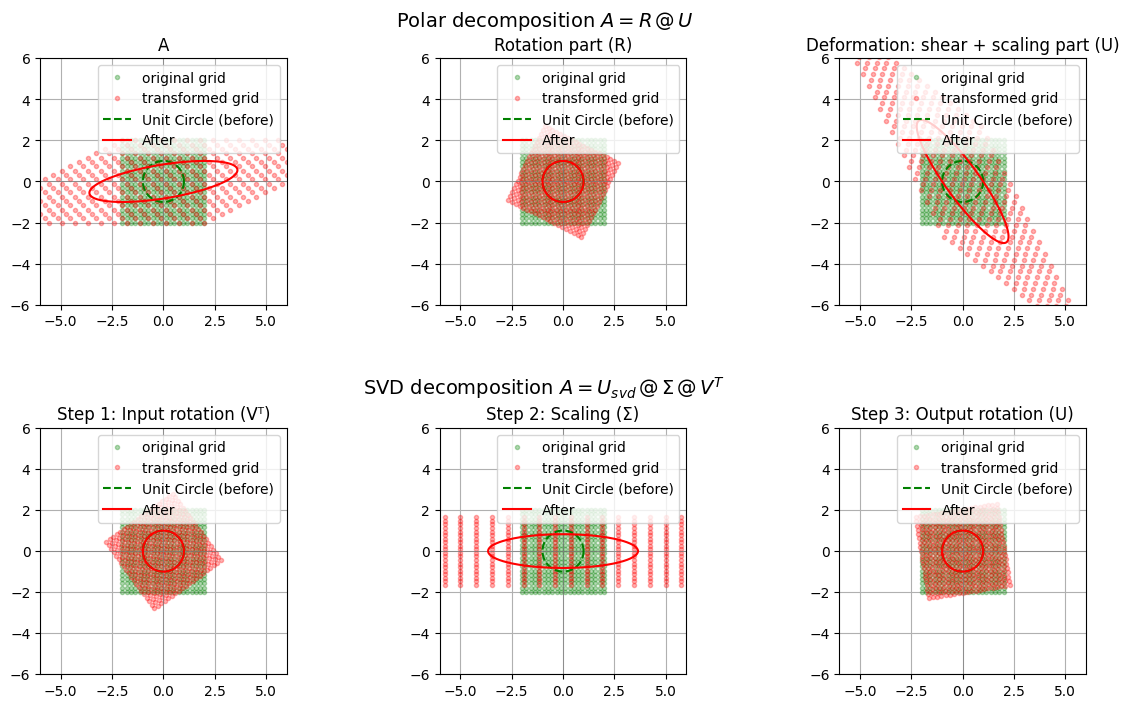

In [7]:
import numpy as np
from scipy.linalg import polar, svd

# Define the matrix A
A = np.array([[2, -3],
              [1,  0]])




U_svd, Sigma, Vt = svd(A)
A_reconstructed = U_svd @ np.diag(Sigma) @ Vt

R, U = polar(A)
R_polar = R
U_polar = U

{
    "A": A,
    "Polar_Decomposition": {"R (rotation/reflection)": R_polar, "U (symmetric, scaling+shear)": U_polar},
    "SVD": {
        "U (output rotation)": U_svd,
        "Sigma (scaling)": np.diag(Sigma),
        "Vt (input rotation transpose)": Vt
    }
}


import matplotlib.pyplot as plt

def plot_transformation(matrix, title, ax):
    # Define a grid and a unit circle
    grid_range = np.linspace(-2, 2, 20)
    X, Y = np.meshgrid(grid_range, grid_range)
    grid_points = np.vstack([X.ravel(), Y.ravel()])
    transformed_grid = matrix @ grid_points

    # Plot transformed grid
    ax.plot(grid_points[0], grid_points[1], 'b.', color = "green",alpha=0.3, label = "original grid")
    ax.plot(transformed_grid[0], transformed_grid[1], 'b.', color ='red', alpha=0.3, label = "transformed grid")
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.grid(True)
    ax.axhline(0, color='gray', lw=0.5)
    ax.axvline(0, color='gray', lw=0.5)
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)

    # Unit circle before and after transformation
    theta = np.linspace(0, 2 * np.pi, 300)
    circle = np.vstack([np.cos(theta), np.sin(theta)])
    transformed_circle = matrix @ circle
    ax.plot(circle[0], circle[1], 'g--', label='Unit Circle (before)')
    ax.plot(transformed_circle[0], transformed_circle[1], 'r-', label='After')
    ax.legend(loc='upper right')




fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.flatten()

plot_transformation(A, 'A', axs[0])
plot_transformation(R, 'Rotation part (R)', axs[1])
plot_transformation(U, 'Deformation: shear + scaling part (U)', axs[2])


plot_transformation(Vt, 'Step 1: Input rotation (Vᵀ)', axs[3])
plot_transformation(np.diag(Sigma), 'Step 2: Scaling (Σ)', axs[4])
plot_transformation(U_svd, 'Step 3: Output rotation (U)', axs[5])


fig.text(0.5, 0.92, "Polar decomposition $A = R \,@ \,U$", ha='center', fontsize=14)
fig.text(0.5, 0.46, r"SVD decomposition $A = U_{svd}\, @ \,\Sigma\, @ \,V^T$", ha='center', fontsize=14)


plt.subplots_adjust(hspace = 0.5, wspace = 0.1)
plt.show()



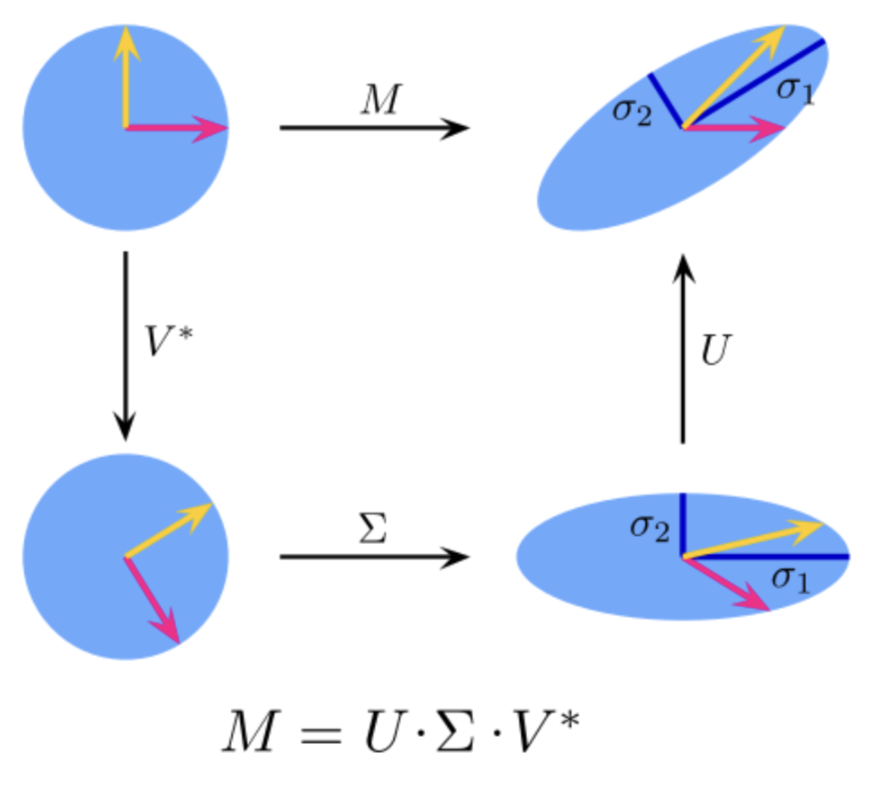

In [20]:
from IPython.display import Image
Image("../Appunti e slides/svd.png", width = 600, height= 600)

I want to understand two things now:

1. How many directions are expanded and how many are compressed, i.e. what is the effective dimensionality of the subspace resulting after the transformation
2. What is the maximum and minimum scaling factor.


I need to look at the eigenvalues of $\Sigma$ only. I will plot them (they are real), check the spectrum and analyze the explained variance.


**Careful**  Since $Q = W_Q\cdot X$, and similarly for the others, the linear transformation to consider is $\vec{y} = W_Q^T\cdot \vec{x}$.

But anyway, as long as we are interested in the singular values only, it makes no difference if we consider $W$ or $W^T$, since

$$
W^T =(U\cdot \Sigma \cdot V^T)^T = V \Sigma U^T
$$

In [13]:
import numpy as np
from scipy.linalg import svd

# Wq, Wk, Wv, W0 list of (D, D) arrays
D = 768
num_heads = 12
d_head = D // num_heads  # = 64
layer_max = 12  # number of transformer layers

Wqt = [qkv_weights[i][:, 0:D].T       for i in range(layer_max)]      # shape (D, D)
Wkt = [qkv_weights[i][:, D:2*D].T     for i in range(layer_max)]      # shape (D, D)
Wvt = [qkv_weights[i][:, 2*D:3*D].T   for i in range(layer_max)]      # shape (D, D)
W0t = [w.T for w in projection_weights]



svd_W0 = [(U, S, Vt) for (U, S, Vt) in map(svd, W0t)]
svd_Wq = [(U, S, Vt) for (U, S, Vt) in map(svd, Wqt)]
svd_Wk = [(U, S, Vt) for (U, S, Vt) in map(svd, Wkt)]
svd_Wv = [(U, S, Vt) for (U, S, Vt) in map(svd, Wvt)]

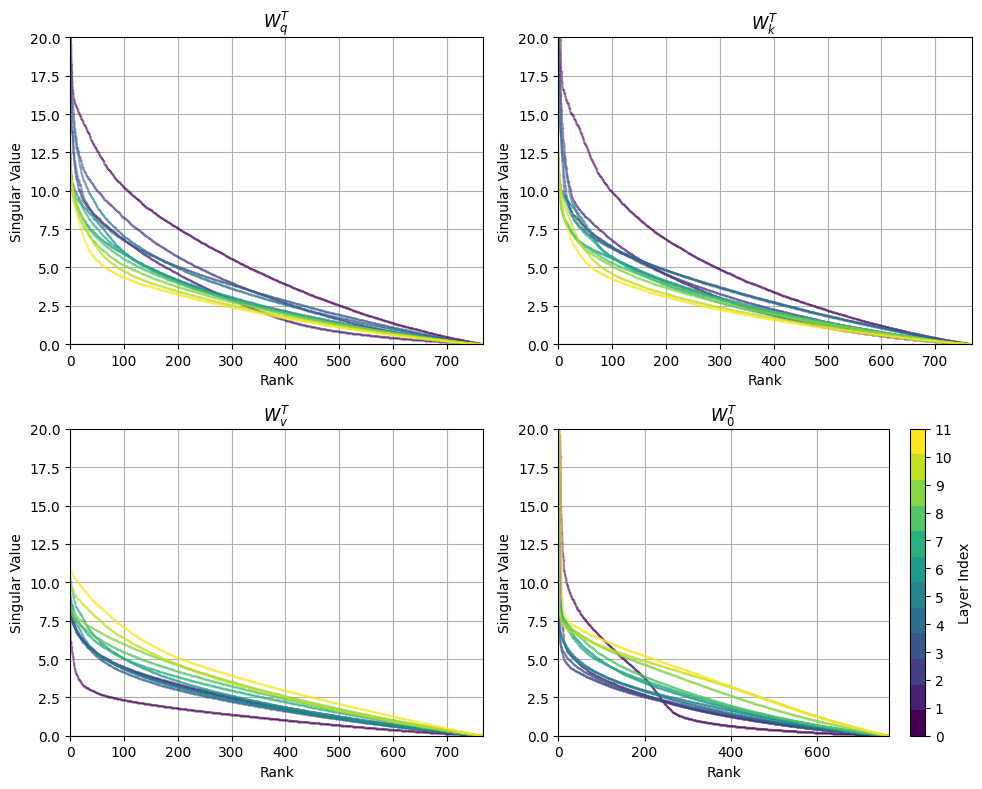

In [14]:
# Get a colormap with N discrete colors from 'viridis'
N = len(svd_W0)
cmap = plt.get_cmap('viridis', N)  # Discretized colormap

def plot_eig(svd_list, ax, title):
    for i, (_, Sigma, _) in enumerate(svd_list):
        ax.plot(Sigma, marker='o', markersize = 0.3, alpha = 0.5, label=f'Matrix {i}', color=cmap(i))
    ax.set_title('Singular Values vs. Rank')
    ax.set_xlabel('Rank')
    ax.set_ylabel('Singular Value')
    ax.set_ylim((0, 20))
    ax.set_xlim((0, D))
    ax.set_title(title)
    ax.grid(True)

# Plot 2: Distribution (histogram)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(2*5, 2*4))
axes = axes.flatten()
plot_eig(svd_Wq, axes[0], title = r"$W_q^T$")
plot_eig(svd_Wk, axes[1], title = r"$W_k^T$")
plot_eig(svd_Wv, axes[2], title = r"$W_v^T$")
plot_eig(svd_W0, axes[3], title = r"$W_0^T$")



# Create colorbar
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
norm = Normalize(vmin=0, vmax=N-1)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for colorbar with ScalarMappable
cbar = plt.colorbar(sm, ax=axes[3], ticks=range(N))
cbar.set_label("Layer Index")
cbar.set_ticks(range(N))
cbar.set_ticklabels([f'{i}' for i in range(N)])


plt.tight_layout()
plt.show()

Notice that singular values decrease with layer idx for the matrices $W_Q, W_K$, while they tend to increase with layer idx for the other two, $W_V$ and $W_0$.

Also the norm of these matrices show the same trend. These things could be linked.

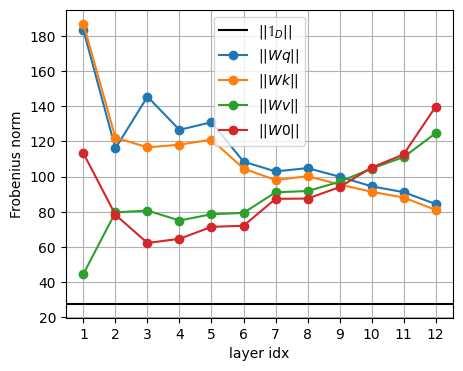

In [15]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,4))
plt.subplots_adjust(hspace = 0.3)


ax.axhline(y = np.linalg.norm(np.eye(D)), color = "black", label = r"$||\mathbb{1}_D||$")
ax.plot(np.arange(1, layer_max + 1), [np.linalg.norm(w) for w in Wq] ,  marker = "o", label = r"$||Wq||$")
ax.plot(np.arange(1, layer_max + 1), [np.linalg.norm(w) for w in Wk] ,  marker = "o", label = r"$||Wk||$")
ax.plot(np.arange(1, layer_max + 1), [np.linalg.norm(w) for w in Wv] ,  marker = "o", label = r"$||Wv||$")
ax.plot(np.arange(1, layer_max + 1), [np.linalg.norm(w) for w in W0] ,  marker = "o", label = r"$||W0||$")

ax.grid()
ax.set_xlabel("layer idx")
ax.set_ylabel("Frobenius norm")
ax.set_xticks(np.arange(1, 13))
ax.legend()
plt.show()

<>:36: SyntaxWarning: invalid escape sequence '\s'
<>:36: SyntaxWarning: invalid escape sequence '\s'
/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_6398/2470998638.py:36: SyntaxWarning: invalid escape sequence '\s'
  ax[0].set_ylabel(f'Singular Value $\sigma_i$')


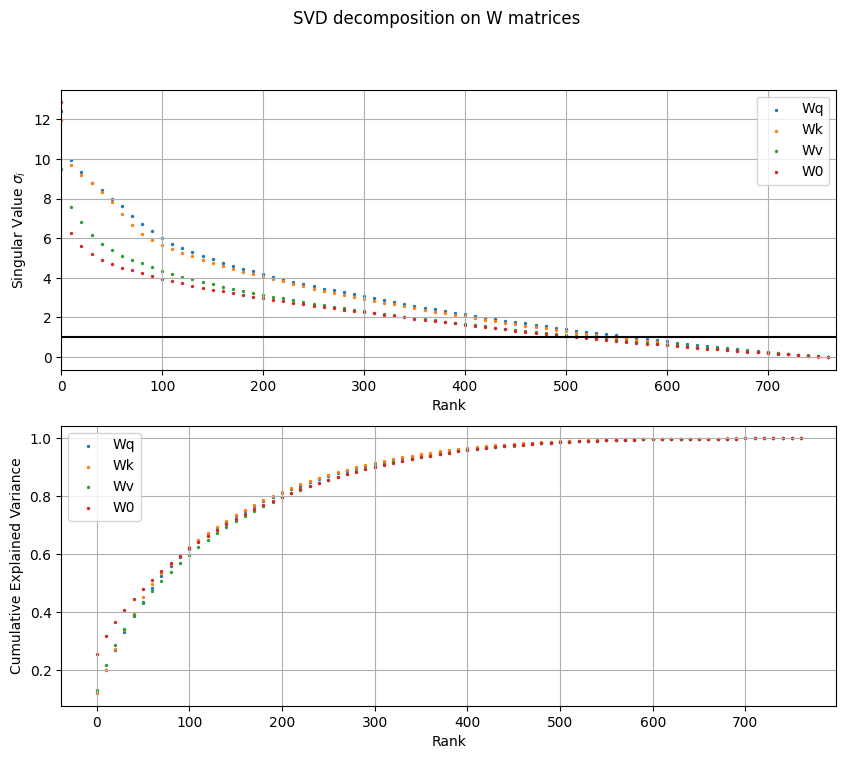

In [33]:
def plot_eigs_layer(svd_list, ax, label, layer_idx = 5):
    every = 10
    Sigma_sorted = [np.sort(Sigma)[::-1] for (_, Sigma, _) in svd_list]  # descending order
    ax.scatter(np.arange(0, D, every), Sigma_sorted[layer_idx][::every], alpha = 1, s = 2, label = label)


def plot_expvar_layer(svd_list, ax, label, layer_idx = 5):
    every = 10
    Sigma_sorted = np.array([np.sort(Sigma)[::-1] for (_, Sigma, _) in svd_list])  # descending order
    Sigma = Sigma_sorted[layer_idx][::every]
    explained_variance = np.cumsum(Sigma**2) / np.sum(Sigma**2)
    ax.scatter(np.arange(0, D, every), explained_variance, alpha = 1, s=2, label = label)


# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 8))


plt.suptitle("SVD decomposition on W matrices")


plot_eigs_layer(svd_Wq, ax[0], "Wq")
plot_eigs_layer(svd_Wk, ax[0], "Wk")
plot_eigs_layer(svd_Wv, ax[0], "Wv")
plot_eigs_layer(svd_W0, ax[0], "W0")

plot_expvar_layer(svd_Wq, ax[1], "Wq")
plot_expvar_layer(svd_Wk, ax[1], "Wk")
plot_expvar_layer(svd_Wv, ax[1], "Wv")
plot_expvar_layer(svd_W0, ax[1], "W0")


ax[0].axhline(y = 1, color = "black")
ax[0].set_xlabel('Rank')
ax[1].set_xlabel('Rank')
ax[0].set_ylabel(f'Singular Value $\sigma_i$')
ax[0].set_xlim((0, D))
ax[1].set_ylabel("Cumulative Explained Variance")
legend = ax[0].legend()
for line in legend.get_lines():
    line.set_linewidth(10)
legend = ax[1].legend()
for line in legend.get_lines():
    line.set_linewidth(10)
ax[0].grid(True)
ax[1].grid(True)


#plt.subplots_adjust(wspace = 0.5, hspace = 0.3)
plt.savefig("../miriam/svd_W_for_slides.png", dpi = 300)

Is it significative that all the matrices reduce R^D to a subspace of the same effective dimensionality (around 500)?


The model has learned to compress the inputs into the most useful directions—akin to unsupervised dimensionality reduction.

### Principal Angles analysis

Let's see how much the spaces of queries (Q), keys (K) and values (V) overlap. Steps:

### ____________________________________________

**Minimal theory**:

Given two subspaces $\mathcal{U}, \mathcal{V} \subseteq \mathbb{R}^n$, of dimensions $d_1$ and $d_2$, the principal angles $\theta_1 \le \theta_2 \le \cdots \le \theta_k$ (with $k = \min(d_1, d_2)$) are defined recursively as:

$$\cos(\theta_i) = \max_{u \in \mathcal{U}, v \in \mathcal{V}} u^\top v \quad \text{subject to} \quad \|u\| = \|v\| = 1, \ u^\top u_j = 0, \ v^\top v_j = 0 \ \forall j < i$$

This means:
- $\theta_1$ is the smallest angle between any unit vector in $\mathcal{U}$ and any in $\mathcal{V}$,
- $\theta_k$ is the largest angle between them,
- $\cos(\theta_i) \in [0,1]$, so $\theta_i \in [0, \pi/2]$.

Computation:

Let $U \in \mathbb{R}^{n \times d_1} and V \in \mathbb{R}^{n \times d_2}$ be orthonormal bases for $\mathcal{U}$ and $\mathcal{V}$. The singular values $\sigma_1 \ge \cdots \ge \sigma_k$ of the matrix $U^\top V$ are the cosines of the principal angles:

$$\sigma_i = \cos(\theta_i)$$


Interpretation:
- Perfect alignment: All $\theta_i = 0$ subspaces coincide (or one is contained in the other).
- Orthogonal subspaces: All $\theta_i = \pi/2$ → no overlap.
- The largest singular value $\sigma_1$ (or smallest angle $\theta_1$) measures the closest alignment.
- The smallest singular value $\sigma_k$ (or largest angle $\theta_k$) indicates the worst alignment among the principal directions.

### ____________________________________________

**Practical steps for computation**

Given two linear transformations $A$ and $B$ on $R^D$:


1. Extract the eigenvectors of the $k$ largest eigenvalues from $U_A$, $U_B$, SVD  ($A = U_A @ \Sigma @ V^T_A$)
2. Compute the matrix $C = U_A^\top U_B$
3. Extract the singular values of $C$ with SVD: $C = U_C@ \Sigma_C @V_C^T$
4. Compute the angles $\theta_i = cos^{-1}(\sigma_i)$
3. Compute average principal angle $\overline{\theta}$ and the overlap score $\text{Overlap} = \frac{1}{k} \| C \|_F^2 \in [0, 1]$


In [20]:
import numpy as np
from scipy.linalg import svd

def principal_angles(U, V):
    """
    Compute principal angles (in radians) between two subspaces spanned by the columns of U and V.

    Parameters:
    - U: Orthonormal basis of subspace 1 (n x d1)
    - V: Orthonormal basis of subspace 2 (n x d2)

    Returns:
    - angles: array of principal angles in radians
    """
    M = U.T @ V
    _, s, _ = svd(M)
    
    # Clamp for numerical stability
    s = np.clip(s, -1.0, 1.0)

    # Compute angles in radians
    angles = np.arccos(s)
    overlap = np.linalg.norm(M, 'fro')**2 / U.shape[1]
    return angles, overlap

Principal angles (degrees): [35.26438968]


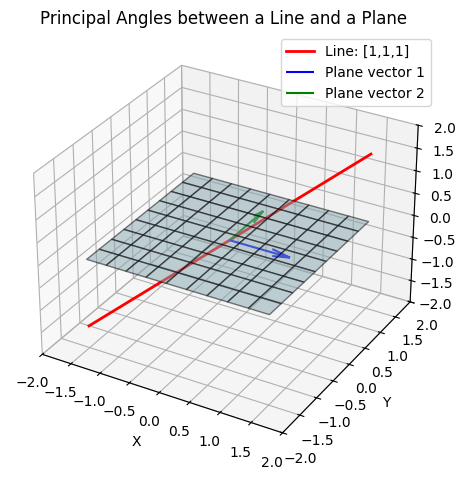

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import svd

def principal_angles(U, V):
    U_orth, _ = np.linalg.qr(U)
    V_orth, _ = np.linalg.qr(V)
    M = U_orth.T @ V_orth
    _, s, _ = svd(M)
    s = np.clip(s, -1.0, 1.0)
    return np.arccos(s)

# Define the plane via two basis vectors (xy-plane)
plane_vec1 = np.array([1, 0, 0])
plane_vec2 = np.array([0, 1, 0])
U = np.column_stack([plane_vec1, plane_vec2])

# Define the line in the direction [1, 1, 1]
line_vec = np.array([1, 1, 1])
V = line_vec.reshape(-1, 1)

# Compute principal angles
angles_rad = principal_angles(U, V)
angles_deg = np.degrees(angles_rad)
print("Principal angles (degrees):", angles_deg)

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the plane (xy-plane)
xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 10), np.linspace(-1.5, 1.5, 10))
zz = np.zeros_like(xx)
ax.plot_surface(xx, yy, zz, alpha=0.5, color='lightblue', edgecolor='k')

# Plot the line: [1, 1, 1] direction, passing through origin
t = np.linspace(-1.5, 1.5, 100)
x_line = t
y_line = t
z_line = t
ax.plot(x_line, y_line, z_line, color='red', linewidth=2, label='Line: [1,1,1]')

# Add the basis vectors for the plane
origin = np.zeros(3)
ax.quiver(*origin, *plane_vec1, color='blue', label='Plane vector 1')
ax.quiver(*origin, *plane_vec2, color='green', label='Plane vector 2')

# Set plot limits and labels
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("Principal Angles between a Line and a Plane")
ax.legend()
plt.tight_layout()
plt.show()

### Now lets do it on the Ws

In [30]:
A = Wq[0]
B = Wq[1]
k = 500  # Effective rank


import numpy as np
from scipy.linalg import svd

def pa_Ws(A, B, k):
    U_A, _, _ = svd(A)
    U_B, _, _ = svd(B)
    U_Ak = U_A[:, :k]
    U_Bk = U_B[:, :k]
    C = U_Ak.T @ U_Bk
    try:
        _, s, _ = svd(C)  # s = cosines of principal angles
    except Exception:
        s = np.full(k, np.nan)  # array of NaNs with length k
    angles_deg = np.degrees(np.arccos(np.clip(s, -1.0, 1.0)))
    mean_angle = np.nanmean(angles_deg)  # ignore NaNs when averaging
    overlap = np.linalg.norm(C, 'fro')**2 / k
    return mean_angle, overlap



**! Following block takes a few minutes**

In [ ]:
k = 400
num_layers = len(Wq)  # Assuming all lists have the same length

# Combine into dictionary for easy access
Ws = {
    'W_Q': Wq,
    'W_K': Wk,
    'W_V': Wv,
    'W_0': W0
}

matrix_names = list(Ws.keys())
num_matrices = len(matrix_names)

# Prepare storage arrays
mean_angles = np.zeros((num_layers, num_layers, num_matrices, num_matrices))
overlaps = np.zeros_like(mean_angles)

# Compute pairwise comparisons across layers and matrix types
for l1 in range(num_layers):
    print(f"Layer {l1}")
    for l2 in range(num_layers):
        for i, name_i in enumerate(matrix_names):
            for j, name_j in enumerate(matrix_names):
                A = Ws[name_i][l1]
                B = Ws[name_j][l2]
                mean_angle, overlap = pa_Ws(A, B, k=k)
                mean_angles[l1, l2, i, j] = mean_angle
                overlaps[l1, l2, i, j] = overlap



np.save()

Layer 0


/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_9358/3248137227.py:20: RuntimeWarning: Mean of empty slice
  mean_angle = np.nanmean(angles_deg)  # ignore NaNs when averaging


Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11


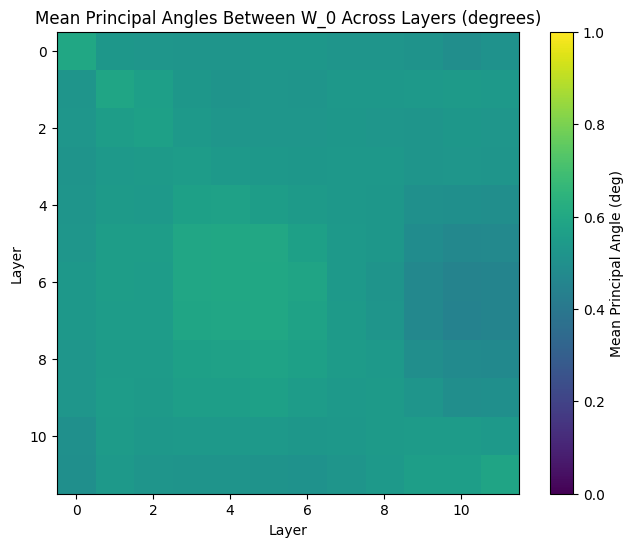

In [42]:
# Example: visualize mean angles for W_0 matrices across layers
fig, ax = plt.subplots(figsize=(8,6))
idx_Wk = matrix_names.index('W_K')
idx_Wv = matrix_names.index('W_V')
overlap_W0 = overlaps[:, :, idx_Wk, idx_Wv]




im = ax.imshow(overlap_W0, cmap='viridis', vmin = 0, vmax = 1, interpolation='none')
ax.set_title('Mean Principal Angles Between W_0 Across Layers (degrees)')
ax.set_xlabel('Layer')
ax.set_ylabel('Layer')
fig.colorbar(im, ax=ax, label='Mean Principal Angle (deg)')



$$

X = 
\begin{bmatrix} 
\quad \vec{x}_1 \quad \\
\quad \vec{x}_2 \quad \\
\quad \cdots  \quad \\
\quad \cdots \quad \\
\quad \vec{x}_N \quad \\
\end{bmatrix} \in \mathbb{R}^{N\times D}
$$


$$

\text{Logits} = E\cdot \vec{x}_N =

\begin{pmatrix}
\langle \vec{t}_1, \vec{x}_N \rangle \\
\langle \vec{t}_2, \vec{x}_N \rangle \\
\quad \cdots \quad \\
\langle \vec{t}_K, \vec{x}_N \rangle \\
\end{pmatrix} \in \mathbb{R}^K
$$


$$
\text{Probabilities} = \frac{1}{Z}\, e^{\text{Logits}}
$$